# Compare Mixing Efficiencies

This code loads a 1D GOTM run, and a 2D Dedalus simulation, and compares the mixing efficiencies.

Note that it is assumed that the two simulations have the same parameters (ie. $\theta$, $N^2$, etc.)

For full analysis of each of these budgets see GOTMEnergetics and EnergyPathways

In [230]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from netCDF4 import Dataset

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [746]:
# Load Dedalus Run

#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
visc = 1e-4
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #Ruan case F

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5' #Ruan case F
# visc = 5e-5

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w']

b = f['tasks']['b'] # Perturbation buoyancy
# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
vgz = f['tasks']['bxbar'][:,0,:]/1e-4
vg = integrate.cumtrapz(vgz, x=z, axis=-1, initial=0)
vg = vg - vg[:,-1][:,np.newaxis]

SGSP = f['tasks']['GSProtated'][:,0,:]*1e-4/(N**2*np.sin(tht[0,0,0]))*vgz
# Energy terms XXX - Need to go clean these up in Dedalus
# gsp = f['tasks']['GSP']
# gspr = f['tasks']['GSProtated']
# vspu = f['tasks']['VSPu']
# vspv = f['tasks']['VSPv']
# vsp = vspu[:,:,:]+vspv[:,:,:]
# lspu = f['tasks']['LSPu']
# lspv = f['tasks']['LSPv']
# lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
dissp = -f['tasks']['DissPartial'][:,:,:]
# dissb = f['tasks']['DISSBPRIME']

# vbf = f['tasks']['VBF']
# vbfr = f['tasks']['VBFr']
# hbfr = f['tasks']['HBFrotated']
# hbfr = hbfr*np.sin(tht[0,0,0])
# vbfrot = f['tasks']['VBFrotated']
# sp = f['tasks']['SP']
# EKE = f['tasks']['EKE']

# # SPECTRAL QUANTITIES
# ws = f['tasks']['wcs']
# bs = f['tasks']['bs']
# vs = f['tasks']['vcs']



# kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

# Calculations
zm = z-z[-1]

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
# up = u - um[:,np.newaxis,:]
# vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(w, axis=-1)/np.gradient(z)
wx = np.gradient(w, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
# EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MKE = 0.5*(um**2 + (vm)**2)
# MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
# MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

bm = np.mean(b, axis=1)
# bmz = np.gradient(bm, axis=-1)/np.gradient(z)
MPE = 0.5*bm**2/N**2
DRAG = -(0.1+vm[:,0])*1e-4*np.sqrt(0*uz[:,0]**2 + vz[:,0]**2)
DRAGG_d = (0.1+vg[:,zlevel])*1e-4*vz[:,zlevel]

mdiss = -visc*uz**2 - visc*vz**2
WDISS = -visc*np.mean(wz**2 + wx**2, axis=1)
WDISS = 0*WDISS

startind=0
zl = range(0, 256)
DISSIT_d = integrate.cumtrapz(integrate.trapz(mdiss[startind:,zl] + diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MPEI_d = integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)[0]
# EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# MIXI_d = integrate.cumtrapz(integrate.trapz(dissb[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
DRAGIT_d = integrate.cumtrapz(DRAG[startind:], x=time[startind:], initial=0)
time_d = time
mdiss_d = mdiss
dissp_d = dissp
diss_d = diss

In [747]:
# Load GOTM

filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/GOTMOUTPUTS/gotm_1e-5_0p02.nc' # Ruan et al. 2019 case F
N2 = 1e-5
tht = 0.02

ds =  Dataset(filename, 'r')  # Dataset is the class behavior to open the file

u1 = np.squeeze(ds.variables['u'])
v1 = np.squeeze(ds.variables['v'])
av = np.squeeze(ds.variables['num'])
b = ds.variables['buoy'][:,:,0,0]

EPS = np.squeeze(ds.variables['eps'])

taub1 = np.squeeze(ds.variables['taub'])
drag1 = np.squeeze(ds.variables['drag'][:,0])
time1 = ds.variables['time'][:]

z1 = ds.variables['z1'][:][0,:,0,0]
z = ds.variables['z'][:][0,:,0,0]
bz = np.gradient(b, axis=-1)/np.gradient(z)
vgz = -(bz-N2)*np.sin(tht)/1e-4
vgg = integrate.cumtrapz(vgz, x=z, axis=-1, initial=0)
vgg = vgg - vgg[:,-1][:,np.newaxis]
# bpert = b + N2*(z-z[0])

taux1 = -1035*((av[:,1][:,np.newaxis])*(np.gradient(u1, axis=-1))/np.gradient(z))[:,0]
tauy1 = -1035*((av[:,1][:,np.newaxis])*(np.gradient(v1, axis=-1))/np.gradient(z))[:,0]

DRAG1 = v1[:,0]*tauy1
tmag1 = np.sqrt(tauy1**2 + taux1**2)
zl=1
EPSIT_g = integrate.cumtrapz(integrate.trapz(EPS[:,zl:], axis=-1, x=z1[zl:]), x=time1[:], initial=0)

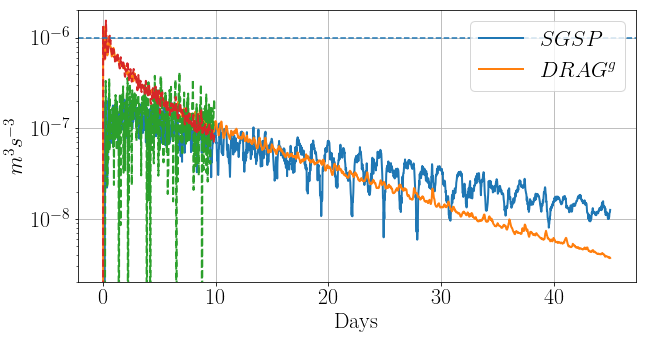

In [381]:
zlevel=0
SGSP_I = integrate.trapz(SGSP, axis=-1, x=z)
SGSP_Id1 = integrate.trapz(SGSP_1, axis=-1, x=z)
plt.figure(figsize=(10,5))
plt.semilogy(time_d/86400, -SGSP_I, linewidth=2, label='$SGSP$')
plt.semilogy(time_d/86400, DRAGG_d, linewidth=2, label='$DRAG^g$')
# plt.semilogy(time_d/86400, DRAGG_d-SGSP_I, linewidth=2, label='$SUM$')

# plt.semilogy(time_d1/86400, -SGSP_Id1, linewidth=2, linestyle='dashed')
plt.semilogy(time_d1/86400, DRAGG_d1, linewidth=2, linestyle='dashed')
plt.axhline(1e-3*0.1**3, linestyle='dashed')
plt.ylim(2e-9, 2e-6)
plt.grid()
plt.xlabel('Days')
plt.ylabel('$m^3 s^{-3}$')
plt.legend()

Text(0,0.5,'Height above bottom (m)')

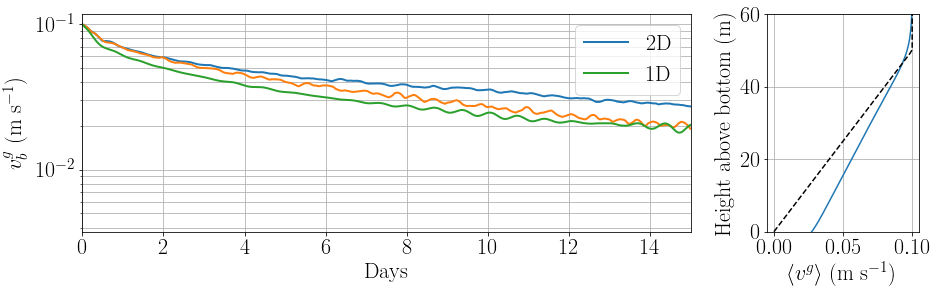

In [775]:

fig, ax = plt.subplots(1, 2, figsize = (15, 4), gridspec_kw={'width_ratios': [4, 1]})

# vg^3
ax[0].semilogy(time_d/86400, (0.1+vg[:,0])**1, linewidth=2, label='2D')
ax[0].plot(time_d1/86400, (0.1+vg1[:,0])**1, linewidth=2)
ax[0].plot(time1/86400, (0.1+vgg[:,0])**1, linewidth=2, label='1D')

#tauy
# ax[0].semilogy(time_d/86400, 1e-4*vz[:,0], linewidth=2, label='2D')
# ax[0].plot(time_d1/86400, 1e-4*vz1[:,0], linewidth=2)
# ax[0].plot(time1/86400, -tauy1/1035, linewidth=2, label='1D')
# ax[0].plot(time_d[1:]/86400, 5e-6*(time_d[1:]/(1e4/0.6**4))**(-1/2))
#tmag
# ax[0].semilogy(time_d/86400, 1e-4*np.sqrt(vz[:,0]**2 + uz[:,0]**2), linewidth=2, label='2D')
# ax[0].plot(time_d1/86400, 1e-4*np.sqrt(vz1[:,0]**2 + uz1[:,0]**2), linewidth=2)
# ax[0].plot(time1/86400, np.sqrt(tauy1**2+taux1**2)/1035, linewidth=2, label='1D')

#Drag geo
# ax[0].semilogy(time_d/86400, (0.1+vg[:,0])*1e-4*vz[:,0], linewidth=2, label='2D')
# ax[0].plot(time_d1/86400, (0.1+vg1[:,0])*1e-4*vz1[:,0], linewidth=2)
# ax[0].plot(time1/86400, -(0.1+vgg[:,0])*tauy1/1035, linewidth=2, label='1D')

#Drag total
# ax[0].semilogy(time_d/86400, (0.1+vm[:,0])*1e-4*vz[:,0], linewidth=2, label='2D')
# ax[0].plot(time_d1/86400, (0.1+vm1[:,0])*1e-4*vz1[:,0], linewidth=2)
# ax[0].plot(time1/86400, -DRAG1/1035, linewidth=2, label='1D')

#Drag geo
# ax[0].plot(time_d/86400, integrate.trapz(um, axis=-1, x=zm), linewidth=2, label='2D')
# ax[0].plot(time_d1/86400, integrate.trapz(um1, axis=-1, x=zm), linewidth=2)
# ax[0].plot(time1/86400, integrate.trapz(u1, axis=-1, x=z), linewidth=2, label='1D')
# ax[0].plot(time_d[1:]/86400, -0.1*(time_d[1:]/(1e4/0.6**4))**(-1/2))


norm = 1.e-3*0.1**3
# plt.plot(time_d/86400, -1e-4*(um[:,0]*uz[:,0] + vm[:,0]*vz[:,0])/norm)
# ax[0].plot(time_d/86400, DRAGG_d/norm, label='Geostrophic drag')

# ax[0].plot(time_d/86400, 1/norm*integrate.trapz(-mdiss_d[startind:,:]-dissp_d[startind:,0,:], x=zm[:], axis=-1), label='$\overline{DISS}$')
# ax[0].plot(time_d/86400, 1/norm*(DRAGG_d+integrate.trapz(-mdiss_d[startind:,:]-dissp_d[startind:,0,:], x=zm[:], axis=-1)), linestyle='dashed', label='Sum')
# plt.ylim(0, 3)
# normg = 2e-3*0.1**3
# plt.plot(time1/86400, -1/normg*((0.1+vgg[:,0])*tauy1/1035))
# ax[0].legend()
# ax[0].set_xlim(0, 20)
# ax[0].grid()
# ax[0].set_xlabel('Days')

# tlim = np.where( (time_d/86400 > 2 )& (time_d/86400<30))[0]
# ax[0].plot(time_d[tlim]/86400, 4e-2*np.exp(-time_d[tlim]/(86400*14)),  linestyle='dashed', color='k')
# ax[0].plot(time_d[tlim]/86400, 7e-2*np.exp(-time_d[tlim]/(86400*22)), linestyle='dashed', color='k')
# t0 = 1e-4/(N**2*tht**2)
# plt.plot(time_d/86400, 6e-2*((time_d/(t0))**(-1/2)), linestyle='dashed')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('$v^g_b$ (m s$^{-1}$)')
ax[0].legend()
ax[0].set_xlim(0, 15)
ax[0].grid(which='both')
# ax[0].set_ylim(5e-6, 1e-3)
# ax[0].set_ylim(2e-8, 2e-6)




# profile plots
t1 = 10
t2 = 20
ts = np.where((time_d/86400>t1) & (time_d/86400<t2))[0]
tsq1 = np.where((time_d1/86400>t1) & (time_d1/86400<t2))[0]

ts1 = np.where((time1/86400>t1) & (time1/86400<t2))[0]

ax[1].plot(np.mean(vg[ts,:], axis=0)+0.1, zm-zm[0])

varrest1 = 1e-5*0.02/1e-4*(zm-zm[0])
varrest1[varrest1>0.1] = 0.1
ax[1].plot(varrest1, zm-zm[0], linestyle='dashed', color='k')

# plt.plot(np.mean(vm[ts,:], axis=0)+0.1, zm)

# ax[1].plot(np.mean(vg1[tsq1,:], axis=0)+0.1, zm-zm[0])
# ax[1].plot(np.mean(v1[ts1,:], axis=0), z+100-zm[0])
# plt.plot(np.mean(v1[ts1,:], axis=0), z+100)
ax[1].set_ylim(0, 60)
# ax[1].set_xlim(0, 0.11)
ax[1].set_xticks([0,  0.05, 0.1])
ax[1].grid()
ax[1].set_xlabel('$\langle v^g \\rangle$ (m s$^{-1}$)')
ax[1].set_ylabel('Height above bottom (m)')

# plt.savefig('GeoDissRatios.pdf', bbox_inches='tight')

In [740]:
(1e4/0.6**4)

77160.49382716049

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


(0, 45)

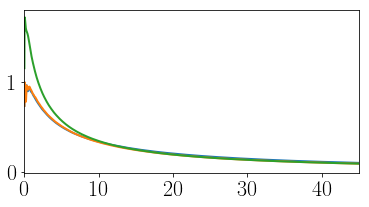

In [639]:
norm = 9e-4*0.1**3
plt.figure(figsize=(6,3))
plt.plot(time_d/86400, 1/(norm*time_d)*integrate.cumtrapz((0.1+vg[:,0])*1e-4*vz[:,0], x=time_d, initial=0), linewidth=2, label='2D')
plt.plot(time_d/86400, 1/(norm*time_d)*integrate.cumtrapz((0.1+vg1[:,0])*1e-4*vz1[:,0], x=time_d, initial=0), linewidth=2, label='2D')
plt.plot(time1/86400, 1/(norm*time1)*integrate.cumtrapz(-(0.1+vgg[:,0])*tauy1/1035, x=time1, initial=0), linewidth=2, label='2D')

plt.xlim(0, 45)
# plt.ylim(0, 1)
# plt.plot(time_d/86400, 1e-3*0.1**3*time_d)
# ax[0].plot(time_d1/86400, (0.1+vg1[:,0])*1e-4*vz1[:,0], linewidth=2)
# ax[0].plot(time1/86400, -(0.1+vgg[:,0])*tauy1/1035, linewidth=2, label='1D')

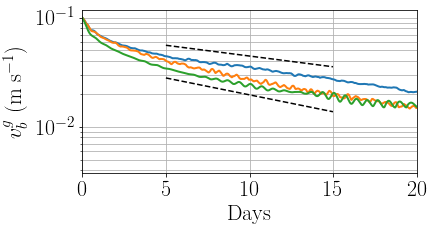

In [695]:
plt.figure(figsize=(6,3))
plt.semilogy(time_d/86400, 0.1+vg[:,0], linewidth=2)
plt.semilogy(time_d1/86400, 0.1+vg1[:,0], linewidth=2)
plt.semilogy(time1/86400, 0.1+vgg[:,0], linewidth=2)

tlim = np.where( (time_d/86400 > 5 )& (time_d/86400<15))[0]
plt.plot(time_d[tlim]/86400, 4e-2*np.exp(-time_d[tlim]/(86400*14)),  linestyle='dashed', color='k')
plt.plot(time_d[tlim]/86400, 7e-2*np.exp(-time_d[tlim]/(86400*22)), linestyle='dashed', color='k')
# t0 = 1e-4/(N**2*tht**2)
# plt.plot(time_d/86400, 6e-2*((time_d/(t0))**(-1/2)), linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('$v^g_b$ (m s$^{-1}$)')
plt.xlim(0, 20)
plt.grid(which='both')
# plt.ylim(2e-2, 1e-1)

(5e-09, 1e-06)

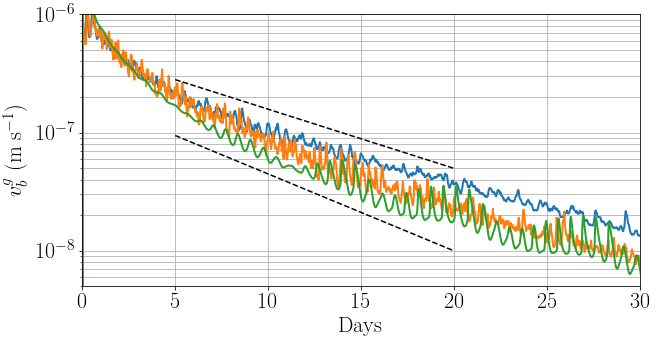

In [687]:
plt.figure(figsize=(10,5))
plt.semilogy(time_d/86400, (0.1+vg[:,0])*1e-4*vz[:,0], linewidth=2)
plt.semilogy(time_d1/86400, (0.1+vg1[:,0])*1e-4*vz1[:,0], linewidth=2)
plt.semilogy(time1/86400, -(0.1+vgg[:,0])*tauy1/1035, linewidth=2)

tlim = np.where( (time_d/86400 > 5 )& (time_d/86400<20))[0]
plt.plot(time_d[tlim]/86400, 2e-7*np.exp(-time_d[tlim]/(86400*20))**3,  linestyle='dashed', color='k')
plt.plot(time_d[tlim]/86400, 5e-7*np.exp(-time_d[tlim]/(86400*20*1.3))**3, linestyle='dashed', color='k')
# t0 = 1e-4/(N**2*tht**2)
# plt.plot(time_d/86400, 6e-2*((time_d/(t0))**(-1/2)), linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('$v^g_b$ (m s$^{-1}$)')
plt.xlim(0, 30)
plt.grid(which='both')
plt.ylim(5e-9, 1e-6)

In [752]:
# Load Dedalus Run

#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_Q1D.h5' #Ruan case F
visc = 1e-4

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5' #Ruan case F
# visc = 5e-5

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w']

b = f['tasks']['b'] # Perturbation buoyancy

# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]

vgz = f['tasks']['bxbar'][:,0,:]/1e-4
vg1 = integrate.cumtrapz(vgz, x=z, axis=-1, initial=0)
vg1 = vg1 - vg1[:,-1][:,np.newaxis]

SGSP_1 = f['tasks']['GSProtated'][:,0,:]*1e-4/(N**2*np.sin(tht[0,0,0]))*vgz

diss = f['tasks']['Diss']
dissp1 = -f['tasks']['DissPartial'][:,:,:]

dissb = f['tasks']['DISSBPRIME']




# kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

# Calculations
zm = z-z[-1]

um1 = np.mean(u, axis=1)
vm1 = np.mean(v, axis=1)
# up = u - um[:,np.newaxis,:]
# vp = v - vm[:,np.newaxis,:]

uz1 = np.gradient(um, axis=-1)/np.gradient(z)
vz1 = np.gradient(vm1, axis=-1)/np.gradient(z) 
wz = np.gradient(w, axis=-1)/np.gradient(z)
wx = np.gradient(w, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
# EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MKE = 0.5*(um**2 + (vm)**2)
# MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
# MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

bm = np.mean(b, axis=1)
# bmz = np.gradient(bm, axis=-1)/np.gradient(z)
MPE = 0.5*bm**2/N**2
DRAGG_d1 = (0.1+vg1[:,zlevel])*1e-4*vz1[:,zlevel]

mdiss = -visc*uz1**2 - visc*vz1**2
WDISS = -visc*np.mean(wz**2 + wx**2, axis=1)
WDISS = 0*WDISS

startind=0
zl = range(0, 256)
DISSIT_d1 = integrate.cumtrapz(integrate.trapz(mdiss[startind:,zl] + diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MPEI_d1 = integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)[0]
# EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MIXI_d1 = integrate.cumtrapz(integrate.trapz(dissb[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
time_d1 = time
mdiss_d1 = mdiss
dissp_d1 = dissp1
diss_d1 = diss

(2160, 2160, 256)

## Make Mixing Efficiency Plot

There are several possible definitions of mixing efficiency that can be considered. All the below are assumed to be vertical integrals.

The first is the change in mean potential energy to the cumulative dissipation. Note that if full Ekman arrest occurs this should become steady.

\begin{equation}
Q = \frac{MPE(t)}{\int_0^t \epsilon dt}
\end{equation}

The next is the ratio of cumulative dissipation of buoyancy variance to cumulative energy dissipation,

\begin{equation}
\Gamma = \frac{\int_0^t \epsilon_b dt}{\int_0^t \epsilon dt}
\end{equation}



/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(0, 0.6)

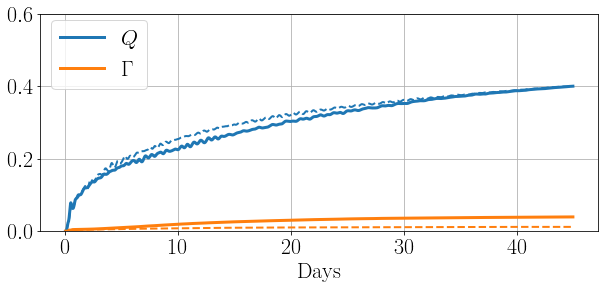

In [588]:
# Ratio of MPE to cumulative dissipation (include both mean and EKE dissipation)



plt.figure(figsize=(10,4))
plt.plot(time_d[startind:]/86400, -MPEI_d/DISSIT_d,linewidth=3, label='$Q$')
plt.plot(time_d1[startind:]/86400, -MPEI_d1/DISSIT_d1,linewidth=2,  linestyle='dashed', color='#1f77b4')
plt.plot(time_d[startind:]/86400, MIXI_d/DISSIT_d,linewidth=3, label='$\Gamma$')
plt.plot(time_d1[startind:]/86400, MIXI_d1/DISSIT_d1,linewidth=2, linestyle='dashed', color='#ff7f0e')

# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
plt.ylim(-0.1,1)
plt.grid()
plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.xlabel('Days')
# plt.xlim(0, 15)
plt.ylim(0, 0.6)

# plt.savefig('./MixingEfficiencies_1e-5_0p02.pdf', bbox_inches='tight')

(0, 0.06)

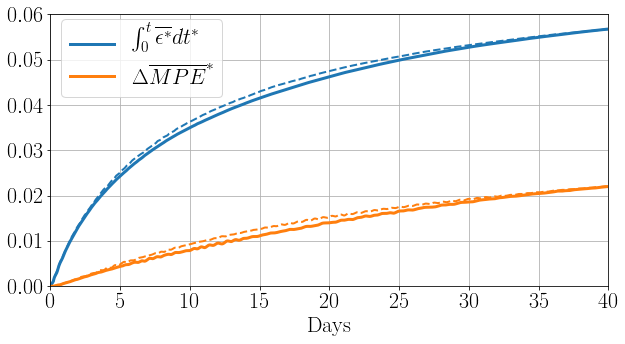

In [589]:
# Plot dissipation rates


norm = 0.1**3*1e4
plt.figure(figsize=(10,5))
plt.plot(time_d[startind:]/86400, -DISSIT_d/(norm),linewidth=3, label='$\int_0^t \overline{\epsilon^*} dt^*$')
plt.plot(time_d1[startind:]/86400, -DISSIT_d1/(norm),linewidth=2,  linestyle='dashed', color='#1f77b4')
plt.plot(time_d[startind:]/86400, MPEI_d/norm,linewidth=3, label='$\Delta \overline{MPE}^*$')
plt.plot(time_d1[startind:]/86400, MPEI_d1/norm,linewidth=2, linestyle='dashed', color='#ff7f0e')
# plt.plot(time[startind:]/86400, 0.1**3*time/(10*1030))
# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
# plt.ylim(-0.1,1)
plt.grid()
plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.xlabel('Days')
plt.xlim(0, 40)
# plt.ylabel('$m^3s^{-2}$')
plt.ylim(0, 0.06)

# plt.savefig('./DISSMPE_1e-5_0p02.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0,0.5,'$m^3s^{-2}$')

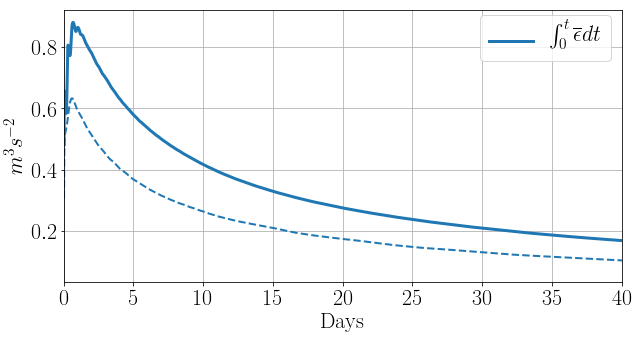

In [117]:
# Plot dissipation rates


norm = 0.1**3*1030**(-1)
plt.figure(figsize=(10,5))
plt.plot(time_d[startind:]/86400, -DISSIT_d/(norm*time_d),linewidth=3, label='$\int_0^t \overline{\epsilon} dt$')
plt.plot(time[startind:]/86400, EPSIT_g/(norm*time),linewidth=2,  linestyle='dashed', color='#1f77b4')
# plt.plot(time_d[startind:]/86400, MPEI_d/norm,linewidth=3, label='$\Delta \overline{MPE}$')
# plt.plot(time[startind:]/86400, MPEI_g/norm,linewidth=2, linestyle='dashed', color='#ff7f0e')
# plt.plot(time[startind:]/86400, 0.1**3*time/(10*1030))
# plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
# plt.ylim(-0.1,1)
plt.grid()
plt.legend(bbox_to_anchor=(0., 0.92, 1., .102))
plt.xlabel('Days')
plt.xlim(0, 40)
plt.ylabel('$m^3s^{-2}$')
# plt.ylim(0, 0.6)

# plt.savefig('./DISSMPE_1e-5_0p02.pdf', bbox_inches='tight')

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: x and y must have same first dimension, but have shapes (476,) and (2160,)

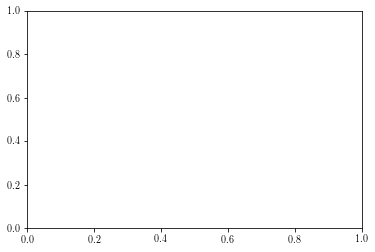

In [4]:

plt.plot(time[startind:]/86400, DISSIT_d[startind:]/DRAGIT_d)
plt.plot(time/86400, DISSIT_d/(1e-3*0.1**3*time))

AxisError: axis -1 is out of bounds for array of dimension 0

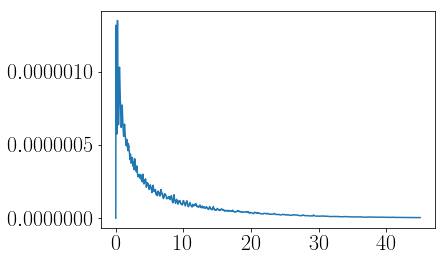

In [674]:
plt.plot(time_d/86400, DRAG)
plt.plot(time_d/86400, DRAG-integrate.trapz(0*mdiss_d[startind:,zl] + diss_d[startind:,0,zl], x=z[zl], axis=-1))
# plt.axhline( 1e-3*0.1**3)
plt.plot(time_d/86400, (0.1-25*1e-5*0.02/1.3e-4)*1e-4*vz[:,zlevel])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


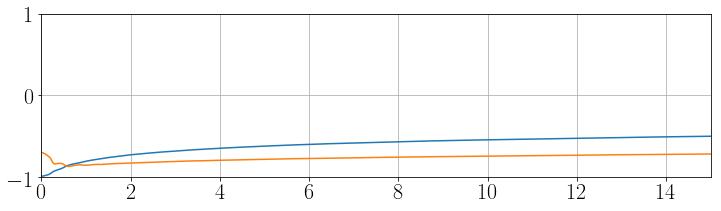

In [829]:
startind = 0
zlevel = 0
DRAG = -(0.1+vg[:,zlevel])*1e-4*vz[:,zlevel] # Positive increases ENERGY OF BBL FLOW
DRAGIT_d = integrate.cumtrapz(DRAG[startind:], x=time_d[startind:], initial=0)
# DRAG1 = (0.1+vg1[:,zlevel])*1e-4*vz1[:,zlevel]
# DRAGIT_d1 = integrate.cumtrapz(DRAG1[startind:], x=time_d1[startind:], initial=0)

norm = 1.e-3*0.1**3*time_d
norm = DRAG[1]*time_d
norm = integrate.cumtrapz(0.1*1e-4*vz[:,zlevel], x=time_d, initial=0)
# norm = 0.1*1e-4*vz[1,zlevel]*time_d

plt.figure(figsize=(12,3))
plt.plot(time_d/86400, DRAGIT_d/norm)
# plt.plot(time_d1/86400, DRAGIT_d1)

plt.plot(time_d/86400, -1/norm*integrate.cumtrapz(integrate.trapz(-mdiss_d[startind:,:]-dissp_d[startind:,0,:], x=zm[:], axis=-1), x=time_d, initial=0))
# plt.plot(time_d1/86400, integrate.cumtrapz(integrate.trapz(-0*mdiss_d1[startind:,zl]-dissp_d1[startind:,0,zl], x=z[zl], axis=-1), x=time_d1, initial=0))

plt.plot(time_d/86400, 1/norm*(DRAGIT_d-integrate.cumtrapz(integrate.trapz(-1*mdiss_d[startind:,:]-diss_d[startind:,0,:], x=zm[:], axis=-1), x=time_d, initial=0)), linestyle='dashed')
# plt.plot(time_d/86400, 1e-3*0.1**3*time_d, linestyle='dashed')
# plt.plot(time_d/86400, integrate.cumtrapz((0.1-25*1e-5*0.02/1.3e-4)*1e-4*vz[:,zlevel], x=time_d, initial=0))
plt.ylim(-1, 1)
plt.xlim(0, 15)
plt.grid()

plt.savefig('GeoDissRatio.pdf', bbox_inches='tight')

In [825]:
DRAG[1]
# DRAGIT_d[1]

1.318480535112937e-06

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


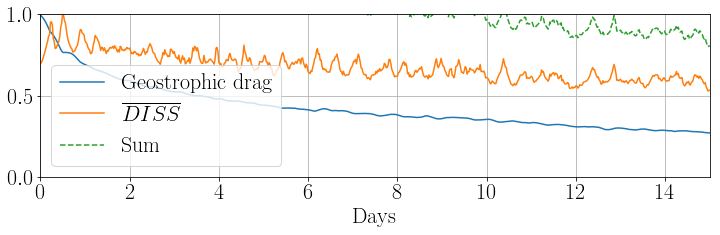

In [833]:
norm = 0.1*1e-4*vz[:,0]
plt.figure(figsize=(12,3))
# plt.plot(time_d/86400, -1e-4*(um[:,0]*uz[:,0] + vm[:,0]*vz[:,0])/norm)
plt.plot(time_d/86400, DRAGG_d/norm, label='Geostrophic drag')

plt.plot(time_d/86400, 1/norm*integrate.trapz(-mdiss_d[startind:,:]-dissp_d[startind:,0,:], x=zm[:], axis=-1), label='$\overline{DISS}$')
plt.plot(time_d/86400, 1/norm*(DRAGG_d+integrate.trapz(-mdiss_d[startind:,:]-dissp_d[startind:,0,:], x=zm[:], axis=-1)), linestyle='dashed', label='Sum')
# plt.ylim(0, 3)
normg = 2e-3*0.1**3
# plt.plot(time1/86400, -1/normg*((0.1+vgg[:,0])*tauy1/1035))
plt.legend()
plt.xlim(0, 15)
plt.ylim(0,1)
plt.grid()
plt.xlabel('Days')
plt.savefig('GeoDissRatio.pdf', bbox_inches='tight')

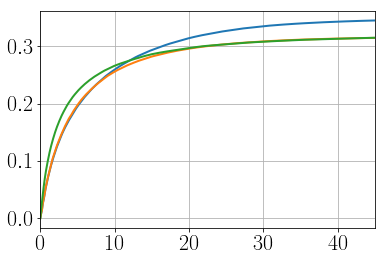

In [670]:
norm = 8e-4*0.1**3*time_d
DRAGGI_d = integrate.cumtrapz(DRAGG_d, x=time_d, initial=0)
plt.plot(time_d/86400, integrate.cumtrapz((0.1+vg[:,0])*1e-4*vz[:,0], x=time_d, initial=0), linewidth=2, label='2D')
plt.plot(time_d1/86400, integrate.cumtrapz((0.1+vg1[:,0])*1e-4*vz1[:,0], x=time_d, initial=0), linewidth=2)
plt.plot(time1/86400, integrate.cumtrapz(-(0.1+vgg[:,0])*tauy1/1035, x=time1, initial=0), linewidth=2, label='1D')


plt.xlim(0, 45)
plt.grid()

In [646]:
DRAGGI_d

array([ 0.00000000e+00, -1.08230958e+00, -5.10184394e+00, ...,
       -1.12588331e+06, -1.12650269e+06, -1.12711666e+06])

In [449]:
zm[25]+200
z[19]+300

4.875

In [573]:
EPSIT_g = integrate.trapz(EPS[:,zl:], axis=-1, x=z1[zl:])
DRAG1 = vgg[:,0]*tauy1

In [705]:
-1e-4*(um[:,0]*uz[:,0] + vm[:,0]*vz[:,0])/(1.3e-3*0.1**3)

array([-0.        ,  1.02225426,  0.73489986, ...,  0.04280762,
        0.04284797,  0.04238462])